In [2]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from preprocessing_helper import *

## 1. Load in preprocessed data

In [3]:
cwd = os.getcwd()
parent_wd = cwd.replace('/preprocessing', '')
url_data_path = parent_wd + '/raw_data/moonGen_scrape_2016_cp'

In [4]:
with open(url_data_path, 'rb') as f:
    MoonBoard_2016_withurl = pickle.load(f)

In [5]:
X_path_all = [cwd + '/benchmark_withgrade_move_seq_X', 
              cwd + '/benchmark_nograde_move_seq_X', 
              cwd + '/nonbenchmark_withgrade_move_seq_X', 
              cwd + '/nonbenchmark_nograde_move_seq_X']
Y_path_all = [cwd + '/benchmark_withgrade_move_seq_Y', 
              cwd + '/benchmark_nograde_move_seq_Y', 
              cwd + '/nonbenchmark_withgrade_move_seq_Y', 
              cwd + '/nonbenchmark_nograde_move_seq_Y']

In [6]:
X_seq_dict_merge = {}
Y_seq_dict_merge = {}
for path in X_path_all:
    with open(path, 'rb') as f:
        read_dict = pickle.load(f)
    X_seq_dict_merge = {**X_seq_dict_merge, **read_dict}
for path in Y_path_all:
    with open(path, 'rb') as f:
        read_dict = pickle.load(f)
    Y_seq_dict_merge = {**Y_seq_dict_merge, **read_dict}

### 1-1. remove data from fail list and save

In [7]:
fail_list = ['363336', 
             '363335', 
             '350368', 
             '349610', 
             '349049', 
             '348915', 
             '348858', 
             '348670', 
             '348669', 
             '348432', 
             '346738', 
             '344743', 
             '339916', 
             '339325', 
             '337916', 
             '335566', 
             '312004', 
             '310949', 
             '309657', 
             '309311', 
             '248997', 
             '246092', 
             '231401', 
             '231392', 
             '19362', 
             '360322', 
             '356219', 
             '322560', 
             '311585', 
             '309230', 
             '308089']

In [8]:
for key in fail_list:
    try:
        del X_seq_dict_merge[key]
    except:
        pass
    try:
        del Y_seq_dict_merge[key]
    except:
        pass
assert len(X_seq_dict_merge) == len(Y_seq_dict_merge)

In [9]:
save_pickle(X_seq_dict_merge, cwd + '/X_seq_dict_merge')
save_pickle(Y_seq_dict_merge, cwd + '/Y_seq_dict_merge')

## 2. Partition to train/dev/test set

### 2-1. convert to matrix form

In [10]:
n_sample = len(Y_seq_dict_merge)
X_seq_data_merge = np.zeros((n_sample, 12, 22))
Y_seq_grade_merge = np.zeros(n_sample)
keys_seq_merge = []
tmax_seq_merge = np.zeros(n_sample)

i = 0
for key, value in X_seq_dict_merge.items():
    X_data = value.T
    X_seq_data_merge[i, 0:X_data.shape[0], :] = X_data
    Y_seq_grade_merge[i] = Y_seq_dict_merge[key]
    keys_seq_merge.append(key)
    tmax_seq_merge[i] = X_data.shape[0]
    i = i + 1

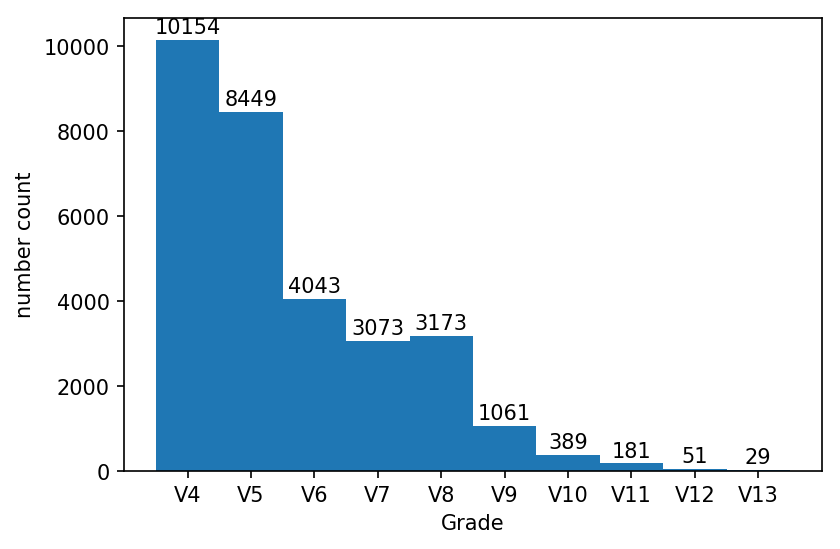

In [11]:
plt.figure(dpi = 150)
result = plt.hist(Y_seq_grade_merge, bins = np.arange(11)-0.5)
for x,y in zip(np.arange(10),result[0]):
    label = str(int(y))
    plt.annotate(label,
                 (x,y), 
                 textcoords="offset points",
                 xytext=(0,3),
                 ha='center')
plt.xticks(np.arange(10), ['V4','V5','V6','V7','V8','V9','V10','V11','V12','V13'])
plt.xlabel('Grade')
plt.ylabel('number count')
plt.show()

### 2-2. Partition

In [12]:
n_dev = 3000
n_test = 3000
n_train = n_sample - n_dev - n_test
print(n_train)

24603


In [13]:
np.random.seed(0)
shuffle = np.random.choice(np.arange(n_sample), n_sample, replace = False)

In [14]:
X_seq_shuffle = X_seq_data_merge[shuffle, :, :]
Y_seq_shuffle = Y_seq_grade_merge[shuffle]
keys_seq_shuffle = np.array(keys_seq_merge)[shuffle]
tmax_seq_shuffle = tmax_seq_merge[shuffle]

In [15]:
training_set_seq = {'X': X_seq_shuffle[0:n_train], 
                'Y': Y_seq_shuffle[0:n_train], 
                'keys': keys_seq_shuffle[0:n_train], 
                'tmax': tmax_seq_shuffle[0:n_train]}
dev_set_seq = {'X': X_seq_shuffle[n_train:n_train+n_dev], 
                'Y': Y_seq_shuffle[n_train:n_train+n_dev], 
                'keys': keys_seq_shuffle[n_train:n_train+n_dev], 
                'tmax': tmax_seq_shuffle[n_train:n_train+n_dev]}
test_set_seq = {'X': X_seq_shuffle[n_train+n_dev:], 
                'Y': Y_seq_shuffle[n_train+n_dev:],  
                'keys': keys_seq_shuffle[n_train+n_dev:], 
                'tmax': tmax_seq_shuffle[n_train+n_dev:]}

In [43]:
# training_set_path = parent_wd + '/preprocessing/training_set_seq_12'
# dev_set_path = parent_wd + '/preprocessing/dev_set_seq_12'
# test_set_path = parent_wd + '/preprocessing/test_set_seq_12'
# save_pickle(training_set_seq, training_set_path)
# save_pickle(dev_set_seq, dev_set_path)
# save_pickle(test_set_seq, test_set_path)

### 2-3. remove problem in dev & test sets that has 0 repeat

In [16]:
del_list = []
for key in training_set_seq['keys']:
    if MoonBoard_2016_withurl[key]['repeats'] == 0:
        del_list.append(key)

del_list_devtest = []
for key in dev_set_seq['keys']:
    if MoonBoard_2016_withurl[key]['repeats'] == 0:
        del_list_devtest.append(key)
for key in test_set_seq['keys']:
    if MoonBoard_2016_withurl[key]['repeats'] == 0:
        del_list_devtest.append(key)

In [17]:
row_rm = []
for i, key in enumerate(training_set_seq['keys']):
    if key in del_list:
        row_rm.append(i)

training_set_seq['X'] = np.delete(training_set_seq['X'], row_rm, 0)
training_set_seq['Y'] = np.delete(training_set_seq['Y'], row_rm)
training_set_seq['keys'] = np.delete(training_set_seq['keys'], row_rm)
training_set_seq['tmax'] = np.delete(training_set_seq['tmax'], row_rm)

In [20]:
row_rm_dev = []
for i, key in enumerate(dev_set_seq['keys']):
    if key in del_list_devtest:
        row_rm_dev.append(i)

dev_set_seq['X'] = np.delete(dev_set_seq['X'], row_rm_dev, 0)
dev_set_seq['Y'] = np.delete(dev_set_seq['Y'], row_rm_dev)
dev_set_seq['keys'] = np.delete(dev_set_seq['keys'], row_rm_dev)
dev_set_seq['tmax'] = np.delete(dev_set_seq['tmax'], row_rm_dev)

row_rm_test = []
for i, key in enumerate(test_set_seq['keys']):
    if key in del_list_devtest:
        row_rm_test.append(i)

test_set_seq['X'] = np.delete(test_set_seq['X'], row_rm_test, 0)
test_set_seq['Y'] = np.delete(test_set_seq['Y'], row_rm_test)
test_set_seq['keys'] = np.delete(test_set_seq['keys'], row_rm_test)
test_set_seq['tmax'] = np.delete(test_set_seq['tmax'], row_rm_test)

#### Visualize the new distribution of data after removing 0 repeat problems

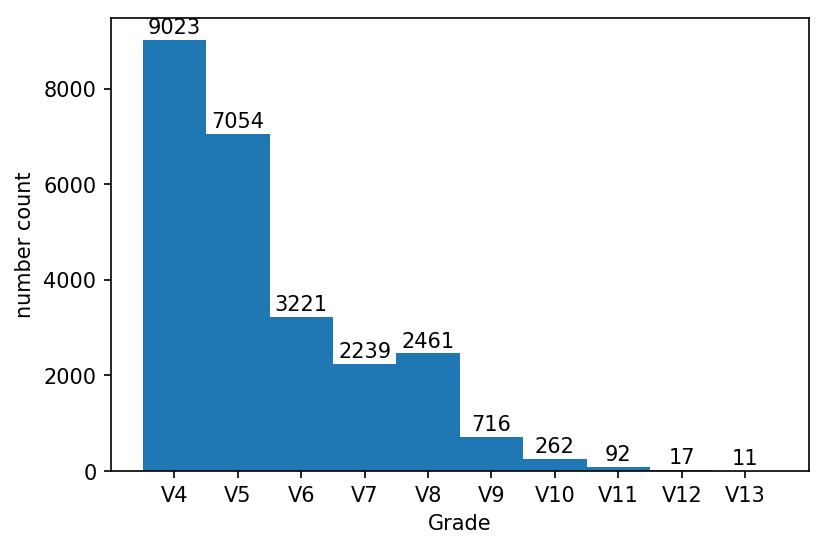

In [21]:
plt.figure(dpi = 150)
result = plt.hist(np.hstack([training_set_seq['Y'], dev_set_seq['Y'], test_set_seq['Y']]), bins = np.arange(11)-0.5)
for x,y in zip(np.arange(10),result[0]):
    label = str(int(y))
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,3),
                 ha='center')
plt.xticks(np.arange(10), ['V4','V5','V6','V7','V8','V9','V10','V11','V12','V13'])
plt.xlabel('Grade')
plt.ylabel('number count')
plt.show()

In [83]:
# training_set_path = parent_wd + '/preprocessing/training_set_seq_12_rmrp0'
# dev_set_path = parent_wd + '/preprocessing/dev_set_seq_12_rmrp0'
# test_set_path = parent_wd + '/preprocessing/test_set_seq_12_rmrp0'
# save_pickle(training_set_seq, training_set_path)
# save_pickle(dev_set_seq, dev_set_path)
# save_pickle(test_set_seq, test_set_path)

### 2-4. normalization

In [22]:
training_seq_normalized = normalization(training_set_seq)
dev_seq_normalized = normalization(dev_set_seq)
test_seq_normalized = normalization(test_set_seq)

### 2-5. save

In [82]:
training_normalized_set_path = parent_wd + '/preprocessing/training_seq_n_12_rmrp0'
dev_normalized_set_path = parent_wd + '/preprocessing/dev_seq_n_12_rmrp0'
test_normalized_set_path = parent_wd + '/preprocessing/test_seq_n_12_rmrp0'
save_pickle(training_seq_normalized, training_normalized_set_path)
save_pickle(dev_seq_normalized, dev_normalized_set_path)
save_pickle(test_seq_normalized, test_normalized_set_path)